# Basic Usage Tutorial for SPIDER + Mujoco Wrap

This is a minimum working example to show how to use SPIDER. Please make sure you have Nvidia GPU and CUDA installed. Create environment with `uv sync`. 

In [5]:
%env MUJOCO_GL=egl

import io
import os

import imageio
import mediapy as media
from IPython.display import Video, Image, display
from huggingface_hub import snapshot_download

from spider.config import Config, process_config
from spider import ROOT

env: MUJOCO_GL=egl


## Prepare Dataset

You can process manually by referring to `spider/process_datasets`. 
Here we use our example dataset where I already downloaded some example data from common datasets. 

In [6]:
# Check if the directory exists
dataset_dir = f"{ROOT}/../example_datasets"
if not os.path.exists(dataset_dir):
    print(f"Dataset not found at {dataset_dir}. Downloading from Hugging Face...")

    # download the repository to the specific folder
    snapshot_download(
        repo_id="retarget/retarget_example",
        repo_type="dataset",
        local_dir=dataset_dir,
        local_dir_use_symlinks=False  # Ensures actual files are copied
    )
    print("Download complete.")
else:
    print("Dataset already exists.")

Dataset already exists.


## Prepare Config

Choose parameters for your task. 

In [ ]:
# choose parameters
# for dexterous hand
# task = "lift_board"
# embodiment_type = "bimanual"
# data_id = 0
# robot_type = "allegro"
# dataset_name = "oakink"
# max_sim_steps = -1 # max step to run, -1 for unlimited

# for humanoid
task = "getup"
embodiment_type = "humanoid"
data_id = 0
robot_type = "unitree_g1"
dataset_name = "lafan"
max_sim_steps = 1000

config = Config(
    robot_type=robot_type,
    embodiment_type=embodiment_type,
    task=task,
    data_id=data_id,
    dataset_name=dataset_name,
    viewer="",
    max_sim_steps=max_sim_steps,
    use_torch_compile=False, # for jupyter
)

# humanoid specific parameters
if embodiment_type == "humanoid":
    config.sim_dt = 1 / 60
    config.ref_dt = 1 / 30
    config.trace_dt = 1 / 30
    config.horizon = 0.8
    config.ctrl_dt = 0.1
    config.knot_dt = 0.1
    config.joint_noise_scale = 0.1
    config.joint_rew_scale = 1.0
    config.pos_rew_scale = 3.0
    config.rot_rew_scale = 3.0
    config.contact_rew_scale = 1.0

process_config(config);

2025-12-22 11:26:48.540 | INFO     | spider.config:process_config:263 - overriding ref_dt: 0.03333333333333333 from task_info.json
2025-12-22 11:26:48.540 | INFO     | spider.config:process_config:269 - overriding contact_site_ids: [4, 7, 11, 14] from task_info.json


## Process Dataset

More dataset processing pipeline can be found in `spider/processed_datasets`. Dataset instruction can be found [here](https://facebookresearch.github.io/spider/development/add-dataset.html). 

In this step, the following things will be done:
1. convert and copy mesh
2. read finger tip, object and wrist position and rotation

In [8]:
if dataset_name == "oakink":
    from spider.process_datasets.oakink import main as process_dataset

    process_dataset(
        dataset_dir=dataset_dir,
        embodiment_type=embodiment_type,
        task=task,
        show_viewer=False,
        save_video=False,
    )
elif dataset_name == "gigahand":
    # NOTE: for gigahands, you might need to use their own conda environment to process
    # their data
    from spider.process_datasets.gigahand import main as process_dataset

    process_dataset(
        dataset_dir=dataset_dir,
        embodiment_type=embodiment_type,
        task=task,
        show_viewer=False,
        save_video=False,
    )
elif dataset_name == "hot3d":
    from spider.process_datasets.hot3d import main as process_dataset

    process_dataset(
        dataset_dir=dataset_dir,
        embodiment_type=embodiment_type,
        task=task,
        show_viewer=False,
        save_video=False,
    )
elif dataset_name == "fair_fre":
    from spider.process_datasets.fair_fre import main as process_dataset

    process_dataset(
        dataset_dir=dataset_dir,
        embodiment_type=embodiment_type,
        task=task,
        show_viewer=False,
        save_video=False,
    )
elif dataset_name in ["lafan", "amass"]:
    from spider.process_datasets.gmr import main as process_dataset

    process_dataset(
        dataset_dir=dataset_dir,
        dataset_name=dataset_name,
        embodiment_type=embodiment_type,
        task=task,
        show_viewer=False,
        save_video=True,
    )

    # show saved video
    video_path = f"{dataset_dir}/processed/{dataset_name}/{robot_type}/{embodiment_type}/{task}/{data_id}/visualization_kinematic.mp4"
    Video(video_path, embed=True, width=600)


Processed directory: /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/unitree_g1/humanoid/getup/0
fps: 30
qpos shape: (5045, 36)
copy from /home/chaoyipan/Research/code/spider/spider/assets/robots/unitree_g1 to /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/assets/robots/unitree_g1
copy from /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/assets/robots/unitree_g1/scene.xml to /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/unitree_g1/humanoid/getup/0/../scene.xml
Saved task info to /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/unitree_g1/humanoid/getup/0/../task_info.json
Saved trajectory to /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/unitree_g1/humanoid/getup/0/trajectory_kinematic.npz
Saved video to /home/chaoyipan/Research/code/spider/example_datasets/processed/lafan/unitree_g1/humanoid/getup/0/visualization_kinematic.mp4
rollout ik tracking error

## Decompose mesh

Mujoco doesn't support mesh decomposition, so we need to decompose the mesh manually. 

In [ ]:
from spider.preprocess.decompose_fast import main as decompose_mesh

if embodiment_type != "humanoid":
    decompose_mesh(
        task=task,
        dataset_dir=dataset_dir,
        dataset_name=dataset_name,
        embodiment_type=embodiment_type,
        data_id=data_id,
        robot_type=robot_type,
    )


SyntaxError: invalid syntax (3971784330.py, line 3)

## Detect Contact

This step is optional, where contact mode is detected with mujoco collision detection. 

In [ ]:
from spider.preprocess.detect_contact import main as detect_contact

# no need for humanoid since it has been done in previous step
if embodiment_type != "humanoid":
    detect_contact(
        task=task,
        dataset_dir=dataset_dir,
        dataset_name=dataset_name,
        embodiment_type=embodiment_type,
        data_id=data_id,
        show_viewer=False,
        save_video=False,
    )

## Generate Scene

Create mujoco scene by compiling objects and robots together. 

In [ ]:
from spider.preprocess.generate_xml import main as generate_xml

if embodiment_type != "humanoid":
    generate_xml(
        task = task,
        dataset_dir = dataset_dir,
        dataset_name = dataset_name,
        embodiment_type = embodiment_type,
        data_id = data_id,
        robot_type = robot_type,
        show_viewer = False,
    )

## Run Kinematic Retargeting

Run kinematic retargeting for specific embodiments. 

IK objective is to match the finger tip position and wrist position/orientation. 

In [ ]:
from spider.preprocess.ik import main as run_ik

if embodiment_type != "humanoid":
    run_ik(
        task=task,
        dataset_dir=dataset_dir,
        dataset_name=dataset_name,
        embodiment_type=embodiment_type,
        data_id=data_id,
        robot_type=robot_type,
        show_viewer=False,
        save_video=True,
    )

# show saved video
    video_path = f"{dataset_dir}/processed/{dataset_name}/{robot_type}/{embodiment_type}/{task}/{data_id}/visualization_ik.mp4"
    Video(video_path, embed=True, width=600)

## Run SPIDER

Finally, we get everything ready and can run SPIDER. 

In [10]:
import mujoco
import numpy as np
import time
import torch

from spider.interp import get_slice
from spider.io import load_data
from spider.optimizers.sampling import (
    make_optimize_fn,
    make_optimize_once_fn,
    make_rollout_fn,
)
from spider.simulators.mjwp import (
    copy_sample_state,
    get_qpos,
    get_qvel,
    get_reward,
    get_terminate,
    get_terminal_reward,
    get_trace,
    load_env_params,
    load_state,
    save_env_params,
    save_state,
    setup_env,
    setup_mj_model,  # mjwp specific
    step_env,
    sync_env,
)
from spider.viewers import render_image, setup_renderer, setup_viewer, update_viewer
from spider.viewers.rerun_viewer import log_frame


Warp 1.11.0.dev20251120 initialized:
   Git commit: bf8830d11365ac5061c779c55b5278d733076d4f
   CUDA Toolkit 12.8, Driver 13.0
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 5090" (31 GiB, sm_120, mempool enabled)
   Kernel cache:
     /home/chaoyipan/.cache/warp/1.11.0.dev20251120


prepare datasets, optimizer and environment

In [11]:
# load reference data (already interpolated and extended)
qpos_ref, qvel_ref, ctrl_ref, contact, contact_pos = load_data(
    config, config.data_path
)
ref_data = (qpos_ref, qvel_ref, ctrl_ref, contact, contact_pos)
config.max_sim_steps = (
    config.max_sim_steps
    if config.max_sim_steps > 0
    else qpos_ref.shape[0] - config.horizon_steps - config.ctrl_steps
)

# setup env with initial state from first sim qpos
env = setup_env(config, ref_data)

# setup mujoco (for viewer only)
mj_model = setup_mj_model(config)
mj_data = mujoco.MjData(mj_model)
mj_data_ref = mujoco.MjData(mj_model)
mj_data.qpos[:] = qpos_ref[0].detach().cpu().numpy()
mj_data.qvel[:] = qvel_ref[0].detach().cpu().numpy()
mj_data.ctrl[:] = ctrl_ref[0].detach().cpu().numpy()
mujoco.mj_step(mj_model, mj_data)
mj_data.time = 0.0
images = []
object_trace_site_ids = []
robot_trace_site_ids = []
for sid in range(mj_model.nsite):
    name = mujoco.mj_id2name(mj_model, mujoco.mjtObj.mjOBJ_SITE, sid)
    if name is not None:
        if name.startswith("trace"):
            if "object" in name:
                object_trace_site_ids.append(sid)
            else:
                robot_trace_site_ids.append(sid)
config.trace_site_ids = object_trace_site_ids + robot_trace_site_ids

# setup env params
env_params_list = []
if config.num_dr == 0:
    xy_offset_list = [0.0]
    pair_margin_list = [0.0]
else:
    xy_offset_list = np.linspace(
        config.xy_offset_range[0], config.xy_offset_range[1], config.num_dr
    )
    pair_margin_list = np.linspace(
        config.pair_margin_range[0], config.pair_margin_range[1], config.num_dr
    )
for i in range(config.max_num_iterations):
    env_params = []
    for j in range(config.num_dr):
        env_params.append(
            {"xy_offset": xy_offset_list[j], "pair_margin": pair_margin_list[j]}
        )
    env_params_list.append(env_params)
config.env_params_list = env_params_list

# setup viewer and renderer
run_viewer = setup_viewer(config, mj_model, mj_data)
renderer = setup_renderer(config, mj_model)

# setup optimizer
rollout = make_rollout_fn(
    step_env,
    save_state,
    load_state,
    get_reward,
    get_terminal_reward,
    get_terminate,
    get_trace,
    save_env_params,
    load_env_params,
    copy_sample_state,
)
optimize_once = make_optimize_once_fn(rollout)
optimize = make_optimize_fn(optimize_once)


Module mujoco_warp._src.smooth 4d4b71e load on device 'cuda:0' took 2.38 ms  (cached)
Module mujoco_warp._src.collision_driver e72006d load on device 'cuda:0' took 0.24 ms  (cached)
Module _nxn_broadphase__locals__kernel_5e1f554f 5e1f554 load on device 'cuda:0' took 0.26 ms  (cached)
Module mujoco_warp._src.collision_primitive._create_narrowphase_kernel f36229d load on device 'cuda:0' took 18.02 ms  (cached)
Module mujoco_warp._src.constraint 4a3aa8f load on device 'cuda:0' took 1.23 ms  (cached)
Module _actuator_velocity__locals__actuator_velocity_c93b8b76 1845902 load on device 'cuda:0' took 1.56 ms  (cached)
Module mujoco_warp._src.passive fc4f8e1 load on device 'cuda:0' took 0.54 ms  (cached)
Module mujoco_warp._src.forward a88f545 load on device 'cuda:0' took 0.68 ms  (cached)
Module mujoco_warp._src.support 769a44d load on device 'cuda:0' took 0.24 ms  (cached)
Module _tile_cholesky_factorize_solve__locals__cholesky_factorize_solve_373adaac 0c61f4b load on device 'cuda:0' took 29

2025-12-22 11:27:39.448 | INFO     | spider.viewers:setup_viewer:106 - viewer is disabled, launch dummy viewer


run retargeting

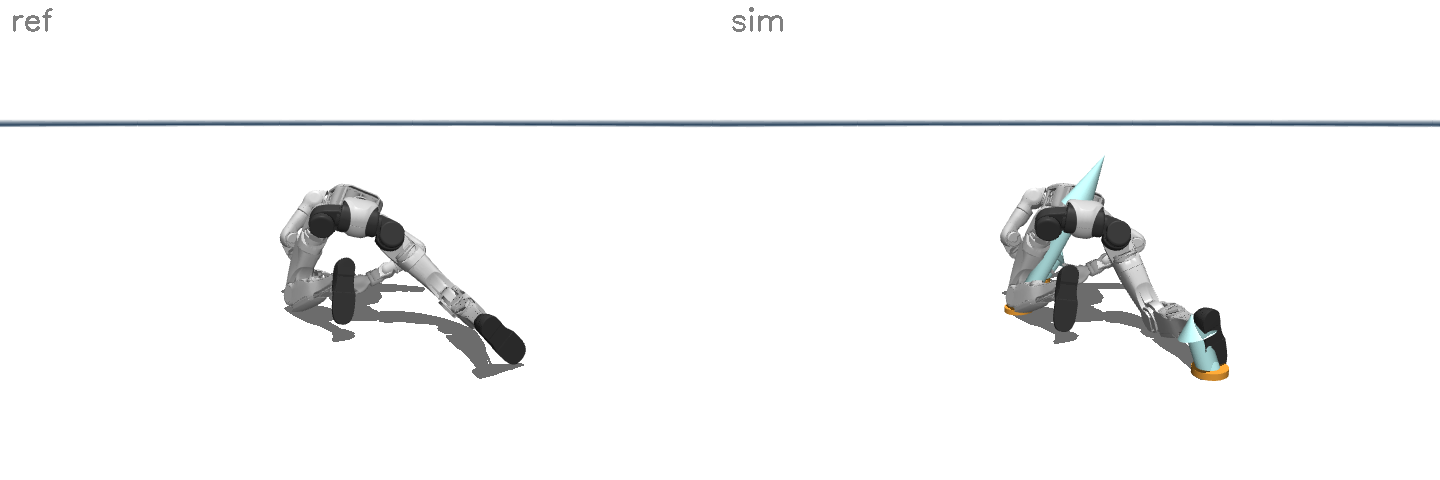

Total time: 40.9011s plan time: 1.3937s, sim_steps: 504/500, opt_steps: 85


In [12]:
# initial controls
ctrls = ctrl_ref[: config.horizon_steps]
# buffers for saving info and trajectory
info_list = []

# jupyter display handle
handle = display(Image(data=b''), display_id=True)

# run viewer + control loop
t_start = time.perf_counter()
with run_viewer() as viewer:
    while viewer.is_running():
        t0 = time.perf_counter()

        # optimize using future reference window at control-rate (+1 lookahead)
        sim_step = int(np.round(mj_data.time / config.sim_dt))
        ref_slice = get_slice(
            ref_data, sim_step + 1, sim_step + config.horizon_steps + 1
        )
        ctrls, infos = optimize(config, env, ctrls, ref_slice)

        # step environment for ctrl_steps
        step_info = {"qpos": [], "qvel": [], "time": [], "ctrl": []}
        for i in range(config.ctrl_steps):
            # option 1: use mujoco step
            # mj_data.ctrl[:] = ctrls[i].detach().cpu().numpy()
            # mujoco.mj_step(mj_model, mj_data)
            # option 2: use warp step
            step_env(config, env, ctrls[i : i + 1])
            mj_data.qpos[:] = get_qpos(config, env)[0].detach().cpu().numpy()
            mj_data.qvel[:] = get_qvel(config, env)[0].detach().cpu().numpy()
            mj_data.ctrl[:] = ctrls[i].detach().cpu().numpy()
            mj_data.time += config.sim_dt
            if config.save_video and renderer is not None:
                if i % int(np.round(config.render_dt / config.sim_dt)) == 0:
                    mj_data_ref.qpos[:] = (
                        qpos_ref[sim_step + i].detach().cpu().numpy()
                    )
                    image = render_image(
                        config, renderer, mj_model, mj_data, mj_data_ref
                    )
                    # update notebook image
                    with io.BytesIO() as buf:
                        imageio.imwrite(buf, image, format='PNG')
                        image_bytes = buf.getvalue()
                    handle.update(Image(data=image_bytes))
                    images.append(image)
            if "rerun" in config.viewer:
                # manually log the state
                log_frame(
                    mj_data,
                    sim_time=mj_data.time,
                    viewer_body_entity_and_ids=config.viewer_body_entity_and_ids,
                )
            step_info["qpos"].append(mj_data.qpos.copy())
            step_info["qvel"].append(mj_data.qvel.copy())
            step_info["time"].append(mj_data.time)
            step_info["ctrl"].append(mj_data.ctrl.copy())
        for k in step_info:
            step_info[k] = np.stack(step_info[k], axis=0)
        infos.update(step_info)
        # sync env state
        sync_env(config, env, mj_data)

        # receding horizon update
        sim_step = int(np.round(mj_data.time / config.sim_dt))
        prev_ctrl = ctrls[config.ctrl_steps :]
        new_ctrl = ctrl_ref[
            sim_step + prev_ctrl.shape[0] : sim_step
            + prev_ctrl.shape[0]
            + config.ctrl_steps
        ]
        ctrls = torch.cat([prev_ctrl, new_ctrl], dim=0)

        # sync viewer state and render
        mj_data.qpos[:] = get_qpos(config, env)[0].detach().cpu().numpy()
        mj_data.qvel[:] = get_qvel(config, env)[0].detach().cpu().numpy()
        mj_data_ref.qpos[:] = qpos_ref[sim_step].detach().cpu().numpy()
        update_viewer(config, viewer, mj_model, mj_data, mj_data_ref, infos)

        # progress
        t1 = time.perf_counter()
        rtr = config.ctrl_dt / (t1 - t0)
        print(
            f"Realtime rate: {rtr:.2f}, plan time: {t1 - t0:.4f}s, sim_steps: {sim_step}/{config.max_sim_steps}, opt_steps: {infos['opt_steps'][0]}",
            end="\r",
        )

        # record info/trajectory at control tick
        # rule out "trace"
        info_list.append({k: v for k, v in infos.items() if k != "trace_sample"})

        if sim_step >= config.max_sim_steps:
            break

    t_end = time.perf_counter()
    print(f"Total time: {t_end - t_start:.4f}s")


In [13]:
# show videos from images
media.show_video(images, fps=int(1 / config.render_dt))